## Homework 7, Problem 2 From PCA to PPCA and FA

ECE C143A/C243A, Spring Quarter 2018, Prof. J.C. Kao, TAs T. Monsoor, X. Jiang and X. Yang.

We will compare PCA, PPCA, and FA on a toy problem using the data in `Xsim`. The data points are $x_k \in R^N$ (k = 1,...,K), where N = 2 is the data dimensionality and K = 8 is the number of data points. We will project the data into a D = 1 dimensional space.

In [5]:
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import random
# Load matplotlib images notebook
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2
data = sio.loadmat('hw7_data.mat') # load the .mat file.
Xplan = data['Xplan']
Xsim = data['Xsim']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### (a) Performing PCA on the data and viewing projections (5 points)

PCA on the data. 
To make this problem a bit simpler, we’ve provided a function `dim_reduce_plot` that, if called correctly, will accept the high-dimensional data, the low-dimensional data, and the PC direction, and plot all these things together for you.

What this function does:

i. Plot each data point $x_k$ as a black dot in a two-dimensional space. 

ii. Plot the mean of the data $\mu$ as a big green point.

iii. Plot the PC space defined by $u_1$ as a black line. (Hint: This line should pass through $\mu$.)

iv. Project each data point into the PC space, and plot each projected data point $\hat{x}_k$ as a red dot. (Hint: The projected points should lie on the $u_1$ line.)

v. Connect each data point $x_k$ with its projection $\hat{x}_k$ using a red line. 


In [6]:
def dim_reduce_plot(Xsim,z_hat_PCA,u1):
    # input: 
    # Xsim is the data, 
    # z_hat_PCA is the low dimensional coordinate of the data, 
    # u1 is the direction of low dimension
    
    plt.figure(figsize=(7,7))
    plt.plot(Xsim[:,0],Xsim[:,1],'k.',markersize=15)
    plt.plot(mu[0],mu[1],'g.',markersize=30)
    scale = 2.5*np.maximum(np.std(Xsim,0)[0],np.std(Xsim,0)[1])/np.linalg.norm(u1);
    xVals = scale*np.array([-u1[0],u1[0]])
    yVals = scale*np.array([-u1[1],u1[1]])
    plt.plot(mu[0]+xVals,mu[1]+yVals,'k')
    dataPC1 = (np.matrix(u1,dtype=float).T*np.matrix(z_hat_PCA,dtype=float)).T+mu
    for i in np.arange(np.size(Xsim,0)):
        plt.plot(dataPC1[i,0],dataPC1[i,1],'r.',markersize=10)
        plt.plot([Xsim[i,0],dataPC1[i,0]],[Xsim[i,1],dataPC1[i,1]],'k')
    plt.axis('equal')
    plt.title('Projection',fontsize=14);
    plt.show()

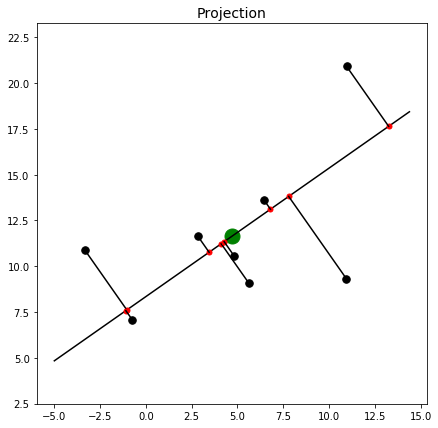

In [9]:
#====================================================#
# YOUR CODE HERE:
#   Use the function dim_reduce_plot to draw a projection plot of PCA
#====================================================#
Xsim_centered = Xsim -np.mean(Xsim, 0)
mu = np.mean(Xsim,0)
[w,v] = np.linalg.eig(np.cov(Xsim.T))
z_hat_PCA = np.matmul(Xsim_centered,v[:,0])
u1 = v[:,0]
dim_reduce_plot(Xsim,z_hat_PCA,u1)
#====================================================#
# END YOUR CODE
#====================================================#   

### (b) (25 points)

Implement the EM algorithm for PPCA , and run the algorithm on the data in Xsim. Plot the log data likelihood 
(Hint: The log data likelihood should increase monotonically with EM iteration. You should run enough EM iterations to see a long, flat plateau.)
(Hint 2: We have provided the function `ppca_nsp` where you can fill in the E-step and the M-step. You ONLY have to fill in the code where noted for the E-step and M-step. Don’t worry about any of the other code -- we’ve calculated those for you. Thus, you should only have to write a few lines of code for the E-step and M-step. You should understand the rest of the code (that we wrote). Note also, we set the random state of this function and also the initial values of $W$ and $\sigma^2$. Therefore, we can tell you that, on the first iteration, our solution has $E[s_k s^T_k ] = 1.01976998$, $W = [1.06663611; 0.85154083]$ and $\sigma^2 = 18.06196687207388$. If you get these values on the first iteration, you implemented the E- and M-step correctly.)

In [10]:
def ppca_nsp(X,D):
    tol = 1e-8
    cyc = np.int(1e8)
    random.seed(1)
    [N,K] = X.shape
    cX = np.cov(X,bias=True)
    W = np.matrix(np.random.rand(N,D),dtype=float)
    s2  = np.mean(np.diag(cX))
    mu  = np.matrix(np.mean(X, 1),dtype=float)
    LL = []
    LL_prev = -1e20;
    for i in np.arange(cyc):
        
        #E-STEP -- compute E[s], E[ss^T]
        
        #Denote E[s] as: Es
        #Denote E[ss^T] as: Ess
        
        #====================================================#
        #START YOUR CODE HERE TO CALCULATE Es and Ess #
        #====================================================#
        R  = W*W.T + s2 * np.identity(N)
        Es = W.T * np.linalg.inv(R)*(X-mu.T)
        covS = np.identity(W.shape[1])-W.T * np.linalg.inv(R) * W
        Ess = covS + Es * Es.T / K
        
        #====================================================#
        #END YOUR CODE HERE TO CALCULATE Es and Ess#
        #====================================================#
        
        #Compute log likelihood
        Sx = W*W.T + s2 * np.identity(N)
        Xm = X-mu.T
        LLi = -N*K/2*np.log(2*np.pi) - K/2*np.log(np.linalg.det(Sx))-1/2*np.trace(Xm.T * np.linalg.inv(Sx) * Xm)
        LL.append(LLi)
        
        
        #M-STEP -- update W, s2
        #====================================================#
        #START YOUR CODE HERE TO CALCULATE W and s2 #
        #====================================================#
        W = Xm * Es.T / (K*Ess)
        s2 = 1/(K*N) * np.trace(Xm*Xm.T - W*Es * Xm.T)
        
        #====================================================#
        #END YOUR CODE HERE TO CALCULATE W and s2 #
        #====================================================#
        
        
        #Check for convergence
        #First iteration, set the base likelihood
        if(i==0):
            LLbase = LLi
            print("In the first iteration")
            print('Ess = ',Ess)
            print('W = ',W)
            print('s2 = ',s2)
        if(LLi < LL_prev):
            disp('LIKELIHOOD VIOLATION!')
        elif ((LLi-LLbase) < (1+tol)*(LL_prev-LLbase)):
            break
        LL_prev = LLi
        
    return [LL,W,s2]

In the first iteration
Ess =  [[1.00162589]]
W =  [[0.3008329 ]
 [0.26692169]]
s2 =  18.93079285881563


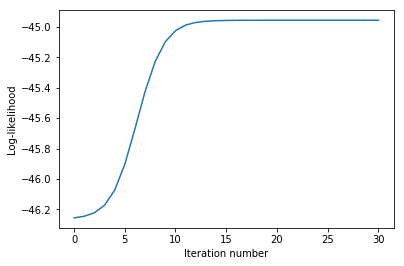

In [11]:
#====================================================#
# START YOUR CODE HERE
#Plot the log likelihood v.s. iteration
#====================================================#
D=1
[LL,W,s2] = ppca_nsp(Xsim.T,D)

plt.figure()
plt.plot(LL)
plt.xlabel('Iteration number');
plt.ylabel('Log-likelihood');
plt.show()
#====================================================#
#END YOUR CODE HERE 
#====================================================#

### (c) (5 points)

Using the parameters found in part (b), what is the PPCA covariance $WW^T + \sigma ^2I$? If you did part (b) correctly, the PPCA covariance should be very similar to the sample covariance.

In [12]:
#====================================================#
# START YOUR CODE HERE
#====================================================#
W*W.T+s2*np.identity(2)

#====================================================#
#END YOUR CODE HERE 
#====================================================#

matrix([[22.43089528,  9.43927826],
        [ 9.43927826, 15.59209341]])

### (d) (5 points)

Create one plot containing all of the following for PPCA, use the `dim_reduce_plot` function

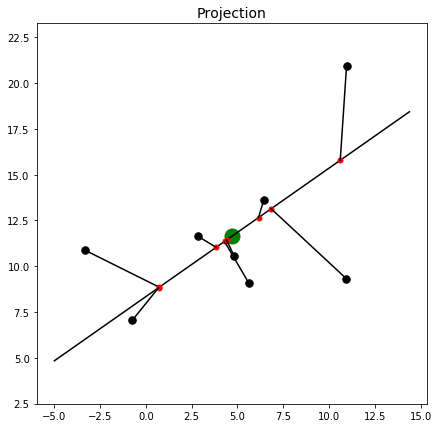

In [18]:
#====================================================#
# START YOUR CODE HERE
#====================================================#
z_hat_PPCA  = W.T*np.linalg.inv(W*W.T + s2*np.identity(2))*Xsim_centered.T
dim_reduce_plot(Xsim,z_hat_PPCA,np.asarray(W.T)[0])

#====================================================#
#END YOUR CODE HERE 
#====================================================#

Question: Why are the red lines no longer orthogonal to the PC space?

Answer: The red lines are no longer orthogonal to the PC space because PPCA projects the data closer to the prior mean, as some of the deviation from the prior mean is attributed to observation noise.

### (e) (20 points)

Implement EM algorithm for FA. You should be able to do this with only a small modification to your PPCA code. By way of hint, you will have to change code in only a few places (there should be changes in the initialization, the E-step, the log likelihood computation, and the M-step). As a word of advice, be sure to get all constants correct (i.e., keep straight your K, N and D variables). Run the algorithm on the data in Xsim. Plot the log data likelihood versus EM iteration. (Hint: The log data likelihood should increase monotonically with EM iteration. You should run enough EM iterations to see a long, flat plateau.)

In [19]:
def fa_nsp(X,D):
    tol = 1e-8
    cyc = np.int(1e8)
    random.seed(1)
    [N,K] = X.shape
    cX = np.cov(X,bias=True)
    W = np.matrix(np.random.rand(N,D),dtype=float)
    s2  = np.diag(cX)
    mu  = np.matrix(np.mean(X, 1),dtype=float)
    LL = []
    LL_prev = -1e20
    for i in np.arange(cyc):
        #E-STEP -- compute E[s], E[ss^T]
        
        #Denote E[s] as: Es
        #Denote E[ss^T] as: Ess
        
        #====================================================#
        #START YOUR CODE HERE TO CALCULATE Es and Ess #
        #====================================================#
        R       = W*W.T + np.diag(s2)
        Es = W.T * np.linalg.inv(R)*(X-mu.T)

        covS = np.identity(W.shape[1])-W.T * np.linalg.inv(R) * W
        Ess = covS + Es * Es.T / K
        #====================================================#
        #END YOUR CODE HERE TO CALCULATE Es and Ess#
        #====================================================#
        
        #Compute log likelihood
        Sx = W*W.T + np.diag(s2)
        Xm = X-mu.T
        LLi = -N*K/2*np.log(2*np.pi) - K/2*np.log(np.linalg.det(Sx))-1/2*np.trace(Xm.T * np.linalg.inv(Sx) * Xm)
        LL.append(LLi)
        
        #M-STEP -- update W, s2
        #====================================================#
        #START YOUR CODE HERE TO CALCULATE W and s2 #
        #====================================================#
        W = Xm * Es.T / (K*Ess)
        s2 = 1/(K) * np.diag(Xm*Xm.T - W*Es * Xm.T)
        
        #====================================================#
        #END YOUR CODE HERE TO CALCULATE W and s2 #
        #====================================================#
        
        
        #Check for convergence
        #First iteration, set the base likelihood
        
        if(i==0):
            LLbase = LLi
            print("In the first iteration")
            print('Ess = ',Ess)
            print('W = ',W)
            print('s2 = ',s2)
        if(LLi < LL_prev):
            print("LIKELIHOOD VIOLATION!",i)
        elif ((LLi-LLbase) < (1+tol)*(LL_prev-LLbase)):
            break
        LL_prev = LLi
    return [LL,W,s2]

In the first iteration
Ess =  [[1.015336]]
W =  [[0.89466785]
 [0.97984229]]
s2 =  [21.61867891 14.61739658]


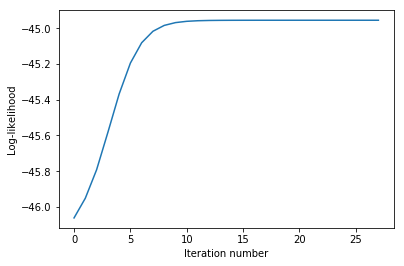

In [20]:
#====================================================#
# START YOUR CODE HERE
#Plot the log likelihood v.s. iteration
#====================================================#
D=1
[LL,W,s2] = fa_nsp(Xsim.T,D)
plt.figure()
plt.plot(LL)
plt.xlabel('Iteration number');
plt.ylabel('Log-likelihood');
plt.show()

#====================================================#
#END YOUR CODE HERE 
#====================================================#

### (f) (5 points)

Using the parameters found in part (e), what is the FA covariance $WW^T + \Psi$? If you did part (e) correctly, the FA covariance should be very similar to the sample covariance.

In [21]:
#====================================================#
# START YOUR CODE HERE
#====================================================#
W*W.T+s2*np.identity(2)

#====================================================#
#END YOUR CODE HERE 
#====================================================#

matrix([[22.43108203,  9.43929423],
        [ 9.43929423, 15.59199985]])

### (g) (5 points)

Create one plot containing all of the following for FA, use the `dim_reduce_plot` function

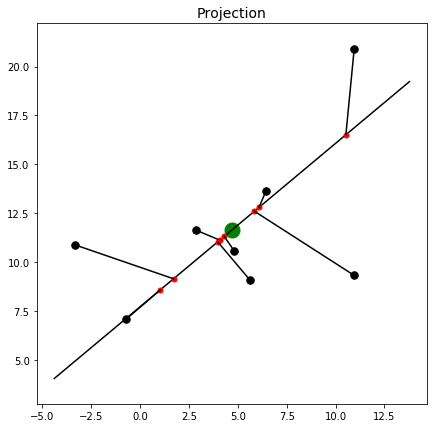

In [22]:
#====================================================#
# START YOUR CODE HERE
#====================================================#
z_hat_FA = W.T*np.linalg.inv(W*W.T + np.diag(s2)*np.identity(2))*Xsim_centered.T
dim_reduce_plot(Xsim,z_hat_FA,np.asarray(W.T)[0])

#====================================================#
#END YOUR CODE HERE 
#====================================================#